In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
from numpy.linalg import svd

from utils import (initialize_matrix, compute_loss, compute_gradient,
                   line_search, armijo_rule, frank_wolfe_matrix_completion,
                   plot_losses_and_gaps, plot_losses_and_gaps_comparison) 

ModuleNotFoundError: No module named 'matplotlib'

## MoviLens Dataset

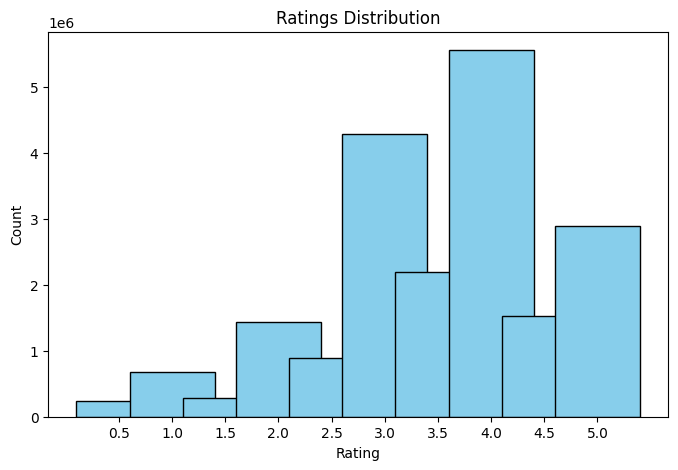

In [2]:
df_ratings=pd.read_csv('./data/ratings.csv')

reviews_groups = df_ratings.groupby("rating")["rating"].count()

plt.figure(figsize=(8, 5))
plt.bar(reviews_groups.index, reviews_groups.values, color='skyblue', edgecolor='black')
plt.title("Ratings Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.xticks(reviews_groups.index)  
plt.show()

In [3]:
item_count = df_ratings["movieId"].unique().shape[0]
user_count = df_ratings["userId"].unique().shape[0]

print("Movies: {}\nUsers: {}".format(item_count, user_count))

Movies: 26744
Users: 138493


In [5]:
df_ratings["movieId_count"] = df_ratings.groupby("movieId")["movieId"].transform("count")
df_ratings["userId_count"] = df_ratings.groupby("userId")["userId"].transform("count")

# Select the top movies and the most active users
movie_quantile = 0.50
user_quantile = 0.935

# Compute the quantiles
movie_threshold = df_ratings["movieId_count"].quantile(movie_quantile)
user_threshold = df_ratings["userId_count"].quantile(user_quantile)

# Filter the DataFrame 
filtered_data = df_ratings[(df_ratings["movieId_count"] >= movie_threshold) & (df_ratings["userId_count"] >= user_threshold)]
R_movielens = pd.pivot_table(filtered_data, values = "rating", index = "userId", columns = "movieId").values

# Replace NaN values with zero
R_movielens[np.isnan(R_movielens)] = 0

print("Top Users count: {}\nTop movies count: {} ".format(R_movielens.shape[0],
                                                        R_movielens.shape[1]))

sparsity = (R_movielens == 0).sum() / (R_movielens.shape[0] * R_movielens.shape[1])
print("Sparsity: {} %".format(round(sparsity * 100, 2)))

Top Users count: 616
Top movies count: 566 
Sparsity: 25.35 %


In [6]:
# Store observed values
observed_indices_movielens = np.argwhere(R_movielens != 0)
observed_indices_movielens = (observed_indices_movielens[:, 0], observed_indices_movielens[:, 1])  
observed_values_movielens = R_movielens[observed_indices_movielens]


In [ ]:
n_rows, n_cols = R_movielens.shape
rank=1
sigma=10000
stopping_conditions = {
    'loss': 1e-5,       
    'dual_gap': 1e-4,   
    'rel_change': 1e-5
}


completed_matrix_movielens, losses_movielens, gaps_movielens = frank_wolfe_matrix_completion(n_rows, n_cols, observed_indices_movielens, observed_values_movielens,
                                                    rank=rank, max_iter=600,  sigma=sigma,
                                                    stopping_conditions=stopping_conditions,
                                                    step_size_method='line_search', print_freq=40)
print("Completed")


Iteration 1, Loss: 163606.69161061582, Dual Gap: 9059658.25874795, Rel Change: 0.2327307092069933, Step Size: 0.044044044044044044
Iteration 41, Loss: 50310.69952495436, Dual Gap: 496524.1518038287, Rel Change: 0.014857564316362799, Step Size: 0.003003003003003003
Iteration 81, Loss: 37728.55581152265, Dual Gap: 396923.52086705575, Rel Change: 0.014264674652510152, Step Size: 0.003003003003003003
Iteration 121, Loss: 29809.890625683183, Dual Gap: 314722.6987515371, Rel Change: 0.009512466042099361, Step Size: 0.002002002002002002
Iteration 161, Loss: 24238.9378979963, Dual Gap: 272998.8234969155, Rel Change: 0.009511096070819626, Step Size: 0.002002002002002002
Iteration 201, Loss: 20201.921778062144, Dual Gap: 239798.91014089136, Rel Change: 0.009665846672742173, Step Size: 0.002002002002002002
Iteration 241, Loss: 17407.184984395102, Dual Gap: 193842.13928782803, Rel Change: 0.008883126521142124, Step Size: 0.002002002002002002
Iteration 281, Loss: 15306.538792041934, Dual Gap: 16795

In [154]:
# 1 - 'diminishing', 2 - 'line_search', 3 - 'armijo'
completed_matrix3, losses3, gaps3 = completed_matrix_movielens, losses_movielens, gaps_movielens

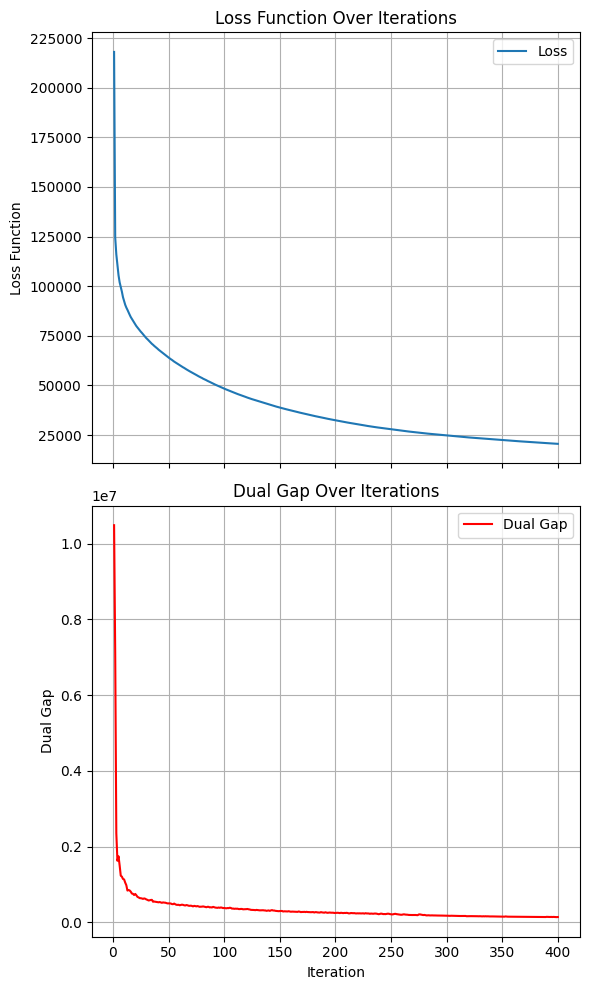

In [169]:
plot_losses_and_gaps(losses_movielens, gaps_movielens)

In [156]:
np.linalg.matrix_rank(completed_matrix_movielens)

np.int64(402)

In [150]:
print(R_movielens[observed_indices_movielens][:20])

array([5. , 5. , 2. , 3. , 4. , 4. , 4. , 5. , 4. , 4. , 4. , 4. , 4. ,
       5. , 3. , 3.5, 2. , 4. , 5. , 3. ])

In [157]:
completed_matrix_movielens[observed_indices_movielens][:20]

array([5.0688235 , 4.66547234, 2.95111667, 3.2273779 , 4.37257764,
       3.84295788, 4.31816269, 4.55583121, 4.09251251, 4.07004321,
       3.61864716, 4.10896337, 4.04810407, 4.63310774, 3.25394337,
       3.673725  , 2.60955588, 4.16785382, 5.04523411, 3.41247188])

In [158]:
def round_to_nearest_half(arr):
    return np.round(arr * 2) / 2 
def relative_accuracy(y_true, y_pred, tolerance=0.5):
    return np.mean(np.abs(np.array(y_true) - np.array(y_pred)) <= tolerance) * 100

print("Accuracy:")
int(relative_accuracy(R_movielens[observed_indices_movielens], completed_matrix_movielens[observed_indices_movielens], tolerance=0.25))

Accuracy:


59

Comparison of different stepsizes

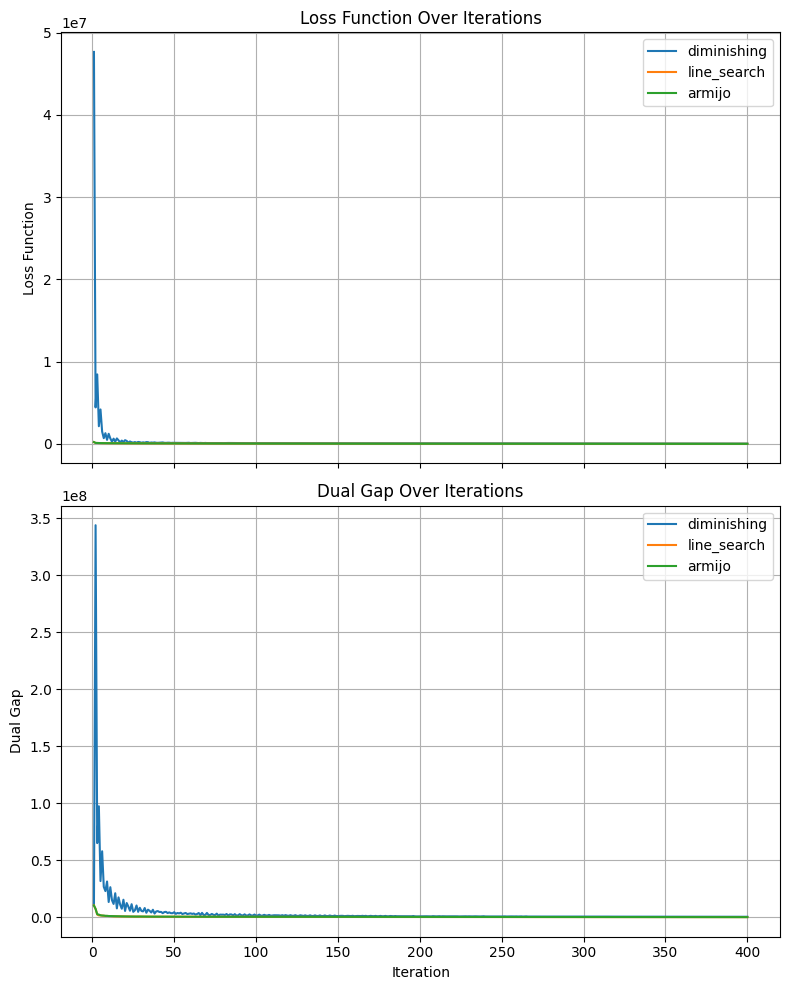

In [163]:
step_size_methods = ['diminishing', 'line_search', 'armijo']
losses_dict = {'diminishing': losses1, 'line_search': losses2, 'armijo': losses3}
gaps_dict = {'diminishing': gaps1, 'line_search': gaps2, 'armijo': gaps3}
plot_losses_and_gaps_comparison(step_size_methods, losses_dict, gaps_dict)

In [165]:
print("Accuracy:")
for i, com_matrix in enumerate([completed_matrix1, completed_matrix2, completed_matrix3]):
    print(step_size_methods[i], int(relative_accuracy(R_movielens[observed_indices_movielens], com_matrix[observed_indices_movielens], tolerance=0.25)), sep=" : ")

Accuracy:
diminishing : 39
line_search : 55
armijo : 59


## Anime Dataset

In [170]:
df_reviews=pd.read_csv('./data/users-score-2023.csv')
df_reviews.columns

Index(['user_id', 'Username', 'anime_id', 'Anime Title', 'rating'], dtype='object')

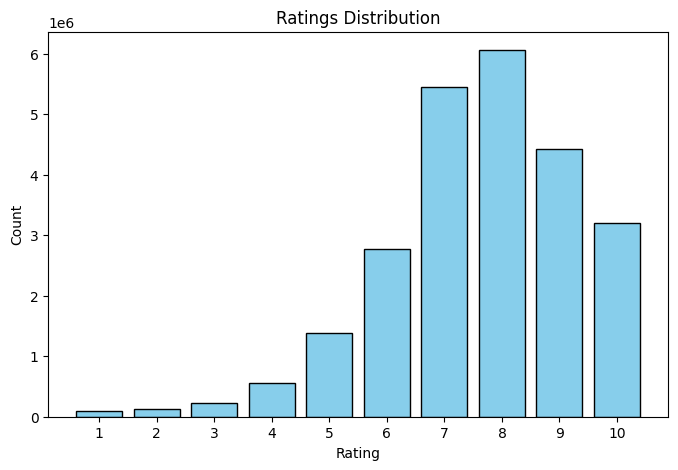

In [171]:
reviews_groups = df_reviews.groupby("rating")["rating"].count()

plt.figure(figsize=(8, 5))
plt.bar(reviews_groups.index, reviews_groups.values, color='skyblue', edgecolor='black')
plt.title("Ratings Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.xticks(reviews_groups.index)  
plt.show()

In [172]:
product_count = df_reviews["anime_id"].unique().shape[0]
user_count = df_reviews["user_id"].unique().shape[0]

print("Products: {}\nUsers: {}".format(product_count, user_count))

Products: 16500
Users: 270033


In [173]:
df_reviews["anime_id_count"] = df_reviews.groupby("anime_id")["anime_id"].transform("count")
df_reviews["user_id_count"] = df_reviews.groupby("user_id")["user_id"].transform("count")

# Select the top movies and the most active users
product_quantile = 0.6
user_quantile = 0.96

# Compute the quantiles
product_threshold = df_reviews["anime_id_count"].quantile(product_quantile)
user_threshold = df_reviews["user_id_count"].quantile(user_quantile)

# Filter the DataFrame 
filtered_data = df_reviews[(df_reviews["anime_id_count"] >= product_threshold) & (df_reviews["user_id_count"] >= user_threshold)]
R_anime = pd.pivot_table(filtered_data, values = "rating", index = "user_id", columns = "anime_id").values

# Replace NaN values with zero
R_anime[np.isnan(R_anime)] = 0

print("Top users count: {}\nTop pproducts count: {} ".format(R.shape[0],
                                                        R.shape[1]))

sparsity = (R_anime == 0).sum() / (R_anime.shape[0] * R.shape[1])
print("Sparsity: {} %".format(round(sparsity * 100, 2)))

Top users count: 832
Top pproducts count: 566 
Sparsity: 21.44 %


In [174]:
# Store observed values
observed_indices_anime = np.argwhere(R_anime != 0)
observed_indices_tuple_anime = (observed_indices_anime[:, 0], observed_indices_anime[:, 1])  
observed_values_anime = R_anime[observed_indices_tuple_anime]

In [186]:
n_rows, n_cols = R_anime.shape
rank=1
sigma=10000
stopping_conditions = {
    'loss': 1e-5,       
    'dual_gap': 1e-4,  
    'rel_change': 1e-5
}



completed_matrix_anime, losses_anime, gaps_anime = frank_wolfe_matrix_completion(n_rows, n_cols, 
                                                observed_indices_tuple_anime, observed_values_anime,
                                                rank=rank, max_iter=400,  sigma=sigma,
                                                stopping_conditions=stopping_conditions,
                                                step_size_method='diminishing', print_freq=20)

print("Completed")

Iteration 1, Loss: 48364339.992796905, Dual Gap: 10345213.387731854, Rel Change: 3.455155719358815, Step Size: 1.0
Iteration 21, Loss: 174369.74437988197, Dual Gap: 10208308.472127516, Rel Change: 0.26607697723843327, Step Size: 0.09090909090909091
Iteration 41, Loss: 169339.81314781736, Dual Gap: 5584620.579075702, Rel Change: 0.15804100373421362, Step Size: 0.047619047619047616
Iteration 61, Loss: 132147.8226818957, Dual Gap: 2834234.078975726, Rel Change: 0.10289473148391266, Step Size: 0.03225806451612903
Iteration 81, Loss: 111996.06279488269, Dual Gap: 2182795.4917978537, Rel Change: 0.05355170284016018, Step Size: 0.024390243902439025
Iteration 101, Loss: 106154.22594607659, Dual Gap: 1581555.0313120792, Rel Change: 0.06027755801813248, Step Size: 0.0196078431372549
Iteration 121, Loss: 94178.61186827994, Dual Gap: 1386513.415233082, Rel Change: 0.04524387501346194, Step Size: 0.01639344262295082
Iteration 141, Loss: 88593.07832690208, Dual Gap: 1224591.7891413108, Rel Change: 0

In [187]:
# 1 - 'diminishing', 2 - 'line_search', 3 - 'armijo'
completed_matrix_anime1, losses_anime1, gaps_anime1 = completed_matrix_anime, losses_anime, gaps_anime

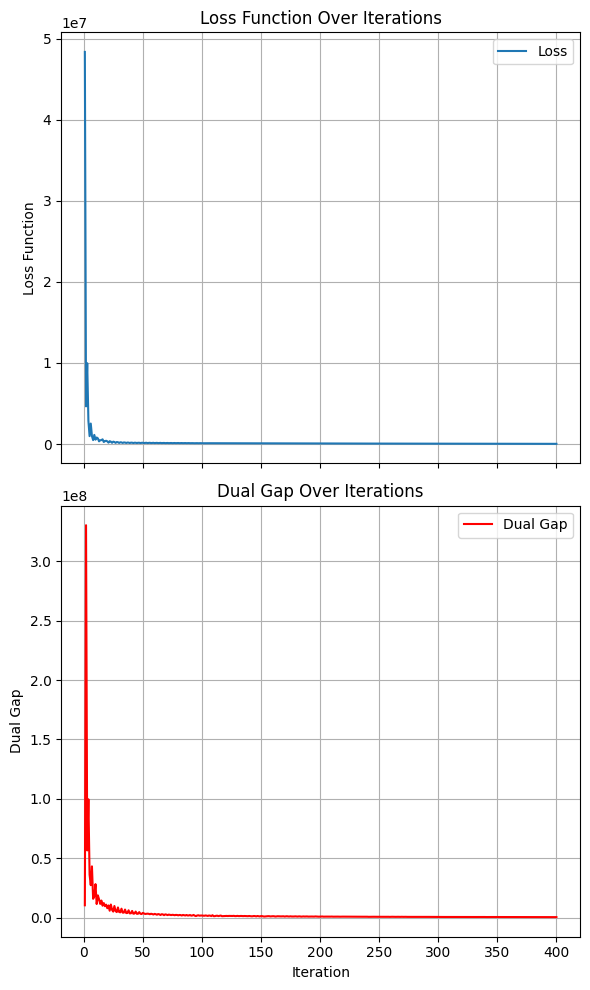

In [188]:
plot_losses_and_gaps(losses_anime, gaps_anime)

In [178]:
R_anime[observed_indices_tuple_anime][:20]


array([7., 8., 6., 7., 7., 7., 8., 7., 6., 7., 7., 7., 5., 8., 6., 8., 8.,
       7., 8., 8.])

In [189]:
completed_matrix_anime[observed_indices_tuple_anime][:20]

array([6.70502641, 7.84647574, 6.7033663 , 7.37308268, 6.92463525,
       6.21095997, 8.46420152, 7.0375789 , 7.05148974, 6.83668222,
       7.62207838, 6.43724571, 5.87437701, 7.10314727, 6.09611177,
       7.95382863, 6.30460899, 6.21131462, 7.32591755, 7.76901967])

In [190]:
def relative_accuracy(y_true, y_pred, tolerance=0.5):
    return np.mean(np.abs(np.array(y_true) - np.array(y_pred)) <= tolerance) * 100

print("Accuracy:")
int(relative_accuracy(R_anime[observed_indices_tuple_anime], completed_matrix_anime[observed_indices_tuple_anime]))

Accuracy:


58

Comparison of different stepsizes

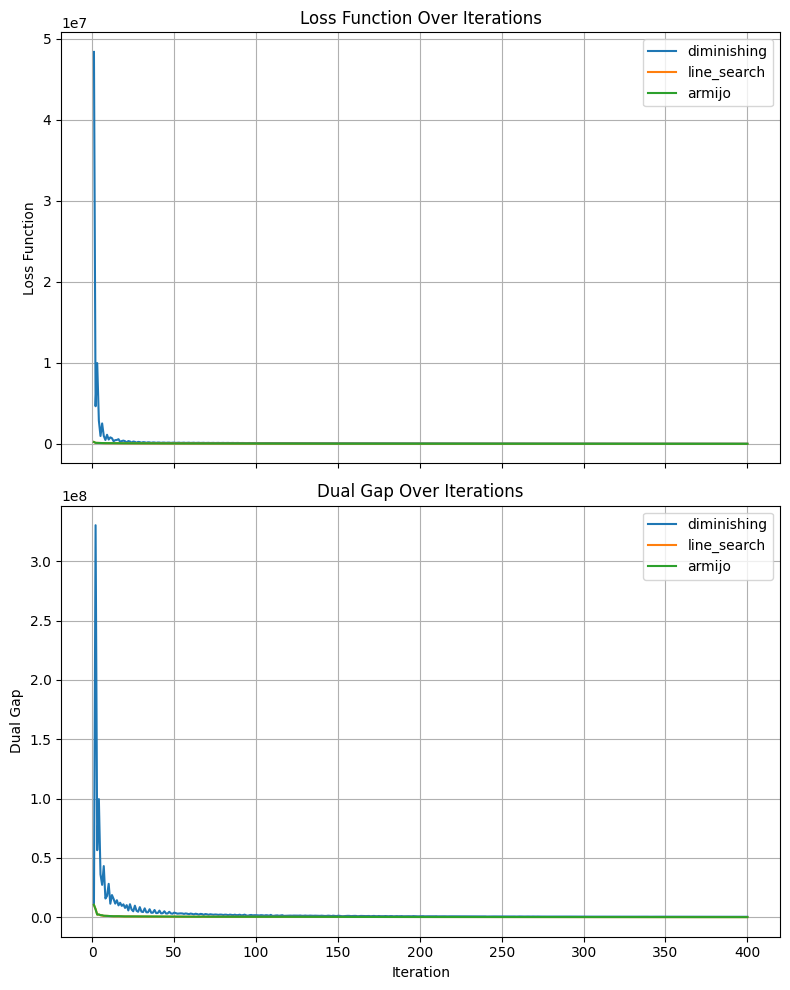

In [191]:
step_size_methods = ['diminishing', 'line_search', 'armijo']
losses_dict = {'diminishing': losses_anime1, 'line_search': losses_anime2, 'armijo': losses_anime3}
gaps_dict = {'diminishing': gaps_anime1, 'line_search': gaps_anime2, 'armijo': gaps_anime3}
plot_losses_and_gaps_comparison(step_size_methods, losses_dict, gaps_dict)

In [192]:
print("Accuracy:")
for i, com_matrix in enumerate([completed_matrix_anime1, completed_matrix_anime2, completed_matrix_anime3]):
    print(step_size_methods[i], int(relative_accuracy(R_anime[observed_indices_tuple_anime], com_matrix[observed_indices_tuple_anime], tolerance=0.5)), sep=" : ")

Accuracy:
diminishing : 58
line_search : 74
armijo : 79
